# problem6

This post is inspired by [Grant Sanderson's awesome 3blue1brown video](https://www.youtube.com/watch?v=OkmNXy7er84&t=1s) which looks at question A6 on the [1992 Putnam](http://www.math.hawaii.edu/~dale/putnam/1992.pdf)

The question is

>Four points are chosen independently and at random on the surface of a sphere (using the uniform distribution). What is the probability that the center of the sphere lies inside the resulting tetrahedron?

The video is brilliant and contains fascinating insight as to how one might have reached the solution. Before reading any further, I highly recommend watching the video because, as Grant points out, the problem solving process is far more interesting than the result and Grant does an incredible job of illuminating how to approach such a problem.

I was so intrigued by the problem that I wanted to take a stab at it myself with a different approach, by running a large number of random simulations and counting our results.

_Note_: this has been done before in [this excellent Medium post](https://towardsdatascience.com/a-simple-monte-carlo-simulation-to-solve-a-putnam-competition-math-problem-28545df6562d), we'll do things slightly differently in a few places so both posts are well worth the read!

## How to check if a point is enclosed within a polygon?

To check whether a point (in our case, the sphere's center) is enclosed within a tetrahedron, we'll use a generalized version of the method described [here](http://steve.hollasch.net/cgindex/geometry/ptintet.html).

We'll start with the slightly simpler 2D case. This method extends to many dimensions but, in two dimensions, it looks like the following:

Given a triangle's vertices and a point $p$

$v1 = (x_1, y_1)$

$v2 = (x_2, y_2)$

$v3 = (x_3, y_3)$

$p = (x_p, y_p)$

The point $p$ is contained within the triangle if the sign of the determinant of all of the following matrices are the same

$
D_0 = 
 \begin{pmatrix}
  x_1 & y_1 & 1 \\
  x_2 & y_2 & 1 \\
  x_3 & y_3 & 1
 \end{pmatrix}
$

$
D_1 = 
 \begin{pmatrix}
  x_p & y_p & 1 \\
  x_2 & y_2 & 1 \\
  x_3 & y_3 & 1
 \end{pmatrix}
$

$
D_2 = 
 \begin{pmatrix}
  x_1 & y_1 & 1 \\
  x_p & y_p & 1 \\
  x_3 & y_3 & 1
 \end{pmatrix}
$

$
D_3 = 
 \begin{pmatrix}
  x_1 & y_1 & 1 \\
  x_2 & y_2 & 1 \\
  x_p & y_p & 1
 \end{pmatrix}
$

In [1]:
from copy import copy, deepcopy
from typing import List

import numpy as np

def contains(point: np.ndarray, vertices: List[np.ndarray]) -> bool:
    """Returns whether point is contained within the given vertices

    Uses a generalized version of this method

    http://steve.hollasch.net/cgindex/geometry/ptintet.html
    """

    if len(point) + 1 != len(vertices):
        raise ValueError("Required that num vertices = dimension + 1")

    for vertex in vertices:
        if len(vertex) != len(point):
            raise ValueError("Dimension of point and vertices do not match")

    # create the matrix D0 above with each vertex stacked vertically
    # and the right-most column filled with 1s
    d0 = deepcopy(vertices)
    d0 = [np.append(vertex, 1) for vertex in d0]

    dimension = len(point)

    # generate a list of the determinants of the matrices described above
    determinants = [np.linalg.det(d0)]

    # create each matrix d1...dn and store the determinant
    for i in range(0, dimension+1):
        d_matrix = copy(d0)
        d_matrix[i] = np.append(point, 1)
        determinants.append(np.linalg.det(d_matrix))

    # return whether the sign of all determinants are the same
    return all(np.sign(det) == np.sign(determinants[0]) for det in determinants)

## Testing Our Implementation

Let's test our implementation by creating a right triangle with vertices $(0, 0)$, $(1, 0)$, and $(0, 1)$ and test that the point $(0.2, 0.2)$ is contained within our triangle while the point $(0.6, 0.6)$ is not.

In [2]:
p1 = np.array([0, 0])
p2 = np.array([1, 0])
p3 = np.array([0, 1])
vertices = [p1, p2, p3]

point = np.array([0.2, 0.2])

assert contains(point, vertices)

point = np.array([0.6, 0.6])
assert not contains(point, vertices)

## Generating a Random Point with Unit Length

In order to generate random points on the unit circle or unit sphere, we'll need to generate random vectors with length one. We can generate random vectors with unit length by creating a vector of random numbers and dividing by the vector's norm.

In [3]:
def random_unit_point(dimension: int) -> np.ndarray:
    """Generate a random point with length 1 for the given dimension

    random_unit_point(dimension=2) returns a random point on the unit circle
    random_unit_point(dimension=3) returns a random point on the unit sphere
    """
    vec = np.array([np.random.randn() for _ in range(dimension)])
    return vec / np.linalg.norm(vec)

## Helper Classes

We'll create two classes that will help us in writing cleaner, more pythonic code for running the simulation. First, we'll create a `Point` class that [subclasses numpy.ndarray](https://docs.scipy.org/doc/numpy/user/basics.subclassing.html), but adds the attributes `x`, `y`, and `z`.

Additionally, we'll create a `Triangle` class that takes the three vertices that form the triangle and implements the magic `__contains__` method, allowing us to write statements like `point in triangle` to check whether a 2D point is enclosed within the triangle.

In [4]:
class Point(np.ndarray):

    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj

    @property
    def x(self):
        return self[0]

    @property
    def y(self):
        return self[1]

    @property
    def z(self):
        return self[2]


class Triangle:

    def __init__(self, p1: np.ndarray, p2: np.ndarray, p3: np.ndarray):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3

    def __contains__(self, point: np.ndarray) -> bool:
        return contains(point, [self.p1, self.p2, self.p3])

In [5]:
p1 = Point([0, 0])
p2 = Point([1, 0])
p3 = Point([0, 1])

assert Point([0.2, 0.2]) in Triangle(p1, p2 , p3)
assert Point([0.6, 0.6]) not in Triangle(p1, p2 , p3)

p2 = Point([-1, 0])
p3 = Point([0, -1])
assert Point([-0.2, -0.2]) in Triangle(p1, p2 , p3)
assert Point([-0.2, 0.2]) not in Triangle(p1, p2 , p3)

## Visualizing our 2D implementation

Here, it'll help us to stop and visualize what we've implemented so far to verify that all looks good. We'll visualize the problem in 2D by generating three random points on the unit circle, drawing the triangle that it forms, and coloring the triangle blue if the origin is enclosed in the triangle or red in the case that it's not. Visualizing this should give us some confidence that our helper classes and impelementation of `contains` looks correct.

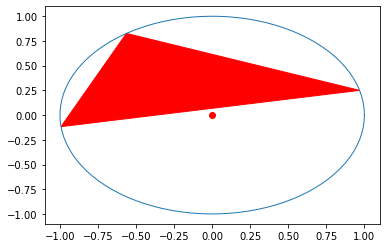

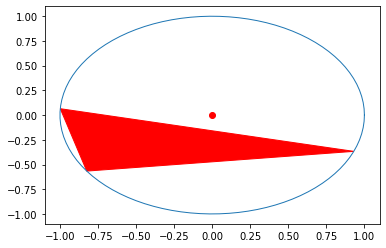

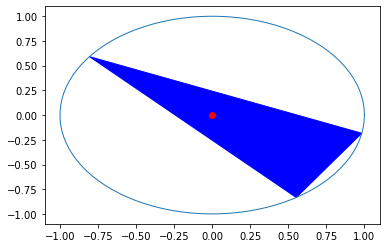

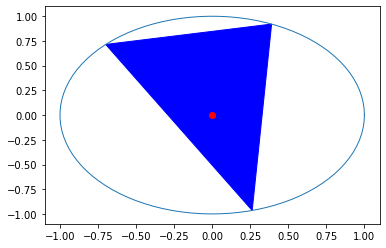

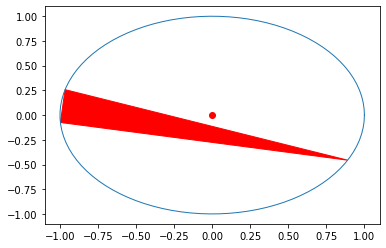

In [6]:
%matplotlib inline

import math
import random
import time

from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

origin = Point([0, 0])

for _ in range(5):

    p1 = random_unit_point(dimension=2)
    p2 = random_unit_point(dimension=2)
    p3 = random_unit_point(dimension=2)

    t = np.linspace(0, np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), linewidth=1)
    plt.plot(origin.x, origin.y, 'ro')

    color = 'blue' if origin in Triangle(p1, p2, p3) else 'red'

    t1 = plt.Polygon([p1, p2, p3], color=color)
    plt.gca().add_patch(t1)
    plt.show()

## Running the simulation

So far so good! We're ready to run our simulation, we'll generate 10,000 triangles and count the number of times that the origin is enclosed within our random triangle.

In [7]:
origin = Point([0, 0])

num_runs = 10**5
times_origin_in_triangle = 0

for _ in range(num_runs):
    p1 = random_unit_point(dimension=2)
    p2 = random_unit_point(dimension=2)
    p3 = random_unit_point(dimension=2)

    t = Triangle(p1, p2, p3)

    times_origin_in_triangle += origin in t

print(
    f"Origin lies within a random triangle on the unit circle "
    f"{100 * times_origin_in_triangle / num_runs}% of the time."
)

Origin lies within a random triangle on the unit circle 25.17% of the time.


## Simulating the 3D Case

The 3D case follows closely from the 2D case, we'll create a `Tetrahedron` class that mirrors our `Triangle` class but with four vertices in three dimensions. Then, we're ready to simulate the creation of 10,000 tetrahedrons and check the number of times that the origin is enclosed.

In [8]:
class Tetrahedron:

    def __init__(self, p1: np.ndarray, p2: np.ndarray, p3: np.ndarray, p4: np.ndarray):
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.p4 = p4

    def __contains__(self, point: np.ndarray) -> bool:
        """Returns whether point is contained within tetrahedron"""
        return contains(point, [self.p1, self.p2, self.p3, self.p4])


p1 = Point([0, 0, 0])
p2 = Point([1, 0, 0])
p3 = Point([0, 1, 0])
p4 = Point([0, 0, 1])
t = Tetrahedron(p1, p2, p3, p4)
assert Point([0.01, 0.01, 0.01]) in t
assert Point([0.5, 0.5, 0.5]) not in t

In [9]:
origin = Point([0, 0, 0])

num_runs = 10**5
num_times_origin_contained = 0

for _ in range(num_runs):
    p1 = random_unit_point(dimension=3)
    p2 = random_unit_point(dimension=3)
    p3 = random_unit_point(dimension=3)
    p4 = random_unit_point(dimension=3)

    t = Tetrahedron(p1, p2, p3, p4)
    num_times_origin_contained += origin in t

print(
    f"Origin lies within random tetrahedron on the unit sphere "
    f"{100 * num_times_origin_contained / num_runs}% of the time."
)

Origin lies within random tetrahedron on the unit sphere 12.612% of the time.


## Additional Resources

If this post was interesting at all, I can hardly say enough good things about the entire [3blue1brown channel](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw) which does an amazing job of providing intuitive visual explanations for challenging concepts. Of particular relevance to this post is a great explanation on [the determinant](https://www.youtube.com/watch?v=Ip3X9LOh2dk).

I've also recently discovered [Jeremy Kun's awesome blog](https://jeremykun.com/) which has nice primers on different areas of mathematics. Jeremy's book, [A Programmer's Introduction to Mathematics](https://pimbook.org/), is on my reading list.

Finally, I struggled mightily with linear algebra throughout school until a friend of mine in grad school recommended Gilbert Strang's [books](http://math.mit.edu/~gs/linearalgebra/) and [lectures](https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/) which helped me a ton with gaining an inuitive understanding of linear algebra concepts.